In [1]:
import dynalearn as dl
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import os

In [2]:
degree = 5
n_nodes = 100
rate = 0.8
T = 50
dt = 0.01
fprefix = 'data/rrg_sis_'
train_sample = 1100
val_sample = 100


In [3]:
# Generating the network
graph = nx.random_regular_graph(degree, n_nodes)
nx.write_edgelist(graph, fprefix + 'edgelist.b')
    
# Generating the time series
continue_simu = False
iter_max = 100
i = 0

data = {}
idx = 0
while(i < train_sample):
    data[idx] = []
    sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt, filename=None,
                                    full_data_mode=True, overwrite=True)
    t = 0
    while(t < T and sisnet.continue_simu and i < train_sample):
        t += dt
        sisnet.update(record=False)
        i += 1
        data[idx].append(sisnet.activity)
    idx += 1

f = open(fprefix + 'states.b', 'wb')
pickle.dump(data, f)
f.close()

%reset_selective -f data

In [4]:
transform = [dl.SIS_StateToFloat(), dl.ResizeData((1, n_nodes))]

dataset = dl.Markov_Dataset(fprefix + 'states.b', pre_transform=transform)

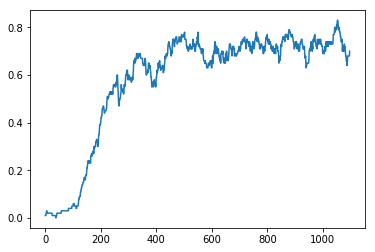

In [5]:
def show_train_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg
avg = show_train_dataset(dataset)
plt.plot(avg)
plt.show()

In [6]:
n_hidden = [16, 8, 4]
n_embedding = 1
keepprob = 1
optimizer = lambda p: torch.optim.Adam(p, lr=1e-3, weight_decay=0)
use_cuda = torch.cuda.is_available()
loss = torch.nn.BCELoss(reduction='sum')



markov_cvae = dl.basicMarkovNodeVAE(graph, n_hidden, n_embedding,
                                    keepprob=keepprob, optimizer=optimizer,
                                    loss=loss, use_cuda=use_cuda)

In [7]:
new_lr = 1e-3
for g in markov_cvae.optimizer.param_groups:
    g['lr'] = new_lr

In [8]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset) - val_sample, val_sample])
markov_cvae.fit(train_dataset, None,
                epochs=20,
                batch_size=128,
                metrics=["recon", "kl_div"],
                show_var=False)

Epoch: 0 - Time: 0.00
	 Train. - loss: 190.7283, recon: 69.6094, kl_div: 121.1189, 
New best Epoch: 1 - Time: 3.61
	 Train. - loss: 172.8055, recon: 69.1367, kl_div: 103.6688, 
New best Epoch: 2 - Time: 2.54
	 Train. - loss: 157.5990, recon: 68.6676, kl_div: 88.9314, 
New best Epoch: 3 - Time: 2.59
	 Train. - loss: 143.2288, recon: 68.1322, kl_div: 75.0966, 
New best Epoch: 4 - Time: 2.56
	 Train. - loss: 129.8949, recon: 67.5026, kl_div: 62.3923, 
New best Epoch: 5 - Time: 2.57
	 Train. - loss: 118.2755, recon: 66.7384, kl_div: 51.5372, 
New best Epoch: 6 - Time: 2.78
	 Train. - loss: 108.6780, recon: 65.7996, kl_div: 42.8784, 
New best Epoch: 7 - Time: 2.75
	 Train. - loss: 100.9599, recon: 64.6481, kl_div: 36.3118, 
New best Epoch: 8 - Time: 2.58
	 Train. - loss: 94.6029, recon: 63.2464, kl_div: 31.3565, 
New best Epoch: 9 - Time: 2.96
	 Train. - loss: 89.0633, recon: 61.5645, kl_div: 27.4989, 


KeyboardInterrupt: 

In [9]:
def test_model(learned_model, dataset):
    init_states = dataset[0][1]
    t = 0
    states, z, past_states = learned_model.predict(init_states, batch_size=2)    
    learned_avg = [np.mean(states)]
    
    while(t < T):
        t += dt
        states, z, past_states = learned_model.predict(past_states, batch_size=2)

        learned_avg.append(np.mean(states))
        states = torch.bernoulli(torch.tensor(states[0]))
        past_states = states
    
    return learned_avg

def show_train_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg

def show_dataset(dataset):
    avg = []
    t = 0
    sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt,
                                    filename=None,
                                    full_data_mode=False,
                                    overwrite=True)
    while t < T:
        t += dt
        sisnet.update(record=False)
        avg_state, std_state = sisnet.get_avg_activity()
        avg.append(avg_state['I'])
    return avg


In [10]:
null_cvae = dl.basicMarkovNodeVAE(graph, n_hidden, n_embedding, keepprob=1,
                                  optimizer=optimizer, loss=loss, use_cuda=use_cuda)

avg_ts = show_dataset(dataset)
trained_ts = test_model(markov_cvae, dataset)
untrained_ts = test_model(null_cvae, dataset)

#avg_ts = show_train_dataset(dataset)


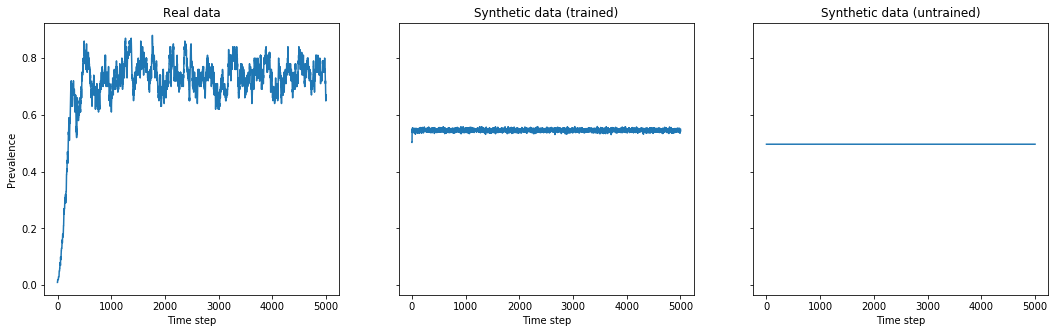

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True,sharey=True)

ax[0].plot(avg_ts)
ax[0].set_title('Real data')
ax[0].set_ylabel('Prevalence')
ax[0].set_xlabel('Time step')

ax[1].plot(trained_ts)
ax[1].set_title('Synthetic data (trained)')
ax[1].set_xlabel('Time step')

ax[2].plot(untrained_ts)
ax[2].set_title('Synthetic data (untrained)')
ax[2].set_xlabel('Time step')

figname = "naive_nodemodel_evol_rrgsis_d{0}_n{1}_rate{2}".format(degree, n_nodes, rate)
fig.savefig("fig/png/" + figname + ".png")
fig.savefig("fig/pdf/" + figname + ".pdf")
plt.show()

In [12]:
def reconstruction_dataset(model, dataset, verbose=True):
    learned = np.zeros(len(dataset))
    real = np.zeros(len(dataset))
    
    for i, d in enumerate(dataset):
        
        if i%1000==0 and verbose: print(str(i) + "/" + str(len(dataset)))
        present, past = d
        sample, _, _ = model.predict(past, batch_size=2)
        learned[i] = np.mean(sample)
        real[i] = np.mean(present.numpy())
        
    return real, learned
        
    

In [16]:
real, learned = reconstruction_dataset(markov_cvae, dataset, False)

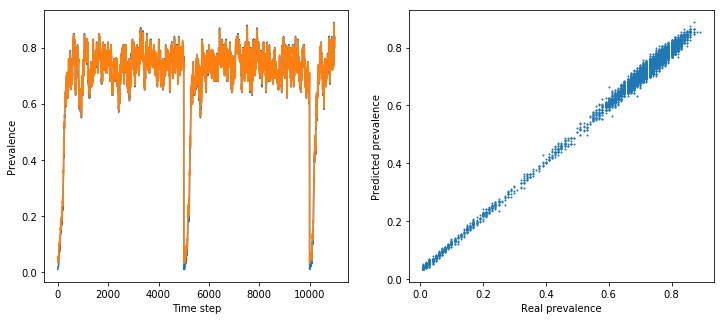

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(real, '-')
ax[0].plot(learned, '-')
fig.savefig(figname + ".png")
fig.savefig(figname + ".pdf")
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('Prevalence')

ax[1].plot(real, learned, '.', markersize=2)
ax[1].set_xlabel('Real prevalence')
ax[1].set_ylabel('Predicted prevalence')

figname = "naive_nodemodel_recon_rrgsis_d{0}_n{1}_rate{2}".format(degree, n_nodes, rate)
fig.savefig("fig/png/" + figname + ".png")
fig.savefig("fig/pdf/" + figname + ".pdf")
plt.show()
